In [26]:
# !pip install autorank
# !pip install scikit_posthocs

In [95]:
import warnings
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from autorank import autorank
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from scipy.stats import friedmanchisquare, sem, t
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

In [28]:
warnings.filterwarnings('ignore')

In [29]:
url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.data"
url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test"

In [30]:
cols = ["CLASS", "REGION-CENTROID-COL", "REGION-CENTROID-ROW", "REGION-PIXEL-COUNT", "SHORT-LINE-DENSITY-5", "SHORT-LINE-DENSITY-2", "VEDGE-MEAN", "VEDGE-SD", "HEDGE-MEAN", "HEDGE-SD", "INTENSITY-MEAN","RAWRED-MEAN","RAWBLUE-MEAN","RAWGREEN-MEAN","EXRED-MEAN","EXBLUE-MEAN","EXGREEN-MEAN","VALUE-MEAN","SATURATION-MEAN","HUE-MEAN"]

In [31]:
data1 = pd.read_csv(url1, header=2, names=cols)
data2 = pd.read_csv(url2, header=2, names=cols)
data = pd.concat([data1, data2])

In [132]:
le = LabelEncoder()

X1 = data.iloc[:, 4:9]
X2 = data.iloc[:, 10:20]
X3 = data.drop(["CLASS", "REGION-CENTROID-COL", "REGION-CENTROID-ROW", "REGION-PIXEL-COUNT"], axis=1)
data["CLASS"] = le.fit_transform(data["CLASS"])
Y = data["CLASS"]

In [33]:
# instanciação do dataframe para o teste de Friedman
d = {
    'Bayesiano Gaussiano': [0.0] * 5,
    'k-NN': [0.0] * 5,
    'Janela de Parzen': [0.0] * 5,
    'Regressão Logística': [0.0] * 5,
    'Voto Majoritário': [0.0] * 5
}
rankings1 = pd.DataFrame(data=d)
rankings2 = pd.DataFrame(data=d)
rankings3 = pd.DataFrame(data=d)

# Questão 2 - a

#### Ajuste do hiper-parâmetro k do k-NN

In [34]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y, train_size=0.8, random_state=999)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, train_size=0.8, random_state=999)
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y, train_size=0.8, random_state=999)

neighborhood = range(1,30)

Melhor valor de k:  16
Acurácia com melhor k:  0.4696969696969697


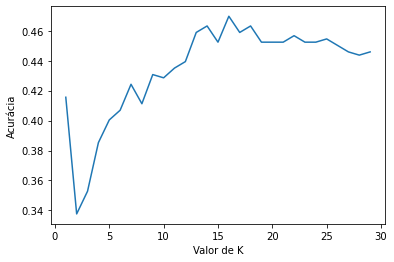

In [35]:
acc = []

for n in neighborhood:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X1_train, Y1_train)
    y_pred = knn.predict(X1_test)
    acc.append(accuracy_score(Y1_test,y_pred))

plt.plot(neighborhood, acc)
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
melhor_k = acc.index(max(acc))
print("Melhor valor de k: ", melhor_k + 1)
print("Acurácia com melhor k: ", max(acc))

Melhor valor de k:  1
Acurácia com melhor k:  0.9112554112554112


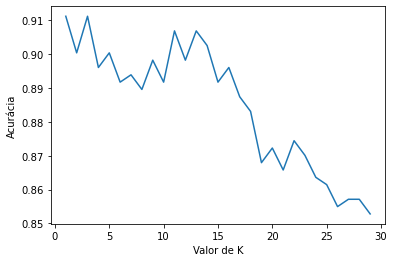

In [36]:
acc = []

for n in neighborhood:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X2_train, Y2_train)
    y_pred = knn.predict(X2_test)
    acc.append(accuracy_score(Y2_test,y_pred))

plt.plot(neighborhood, acc)
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
melhor_k = acc.index(max(acc))
print("Melhor valor de k: ", melhor_k + 1)
print("Acurácia com melhor k: ", max(acc))

Melhor valor de k:  1
Acurácia com melhor k:  0.9155844155844156


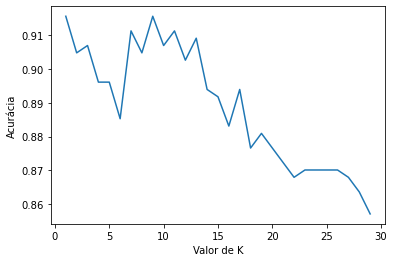

In [37]:
acc = []

for n in neighborhood:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X3_train, Y3_train)
    y_pred = knn.predict(X3_test)
    acc.append(accuracy_score(Y3_test,y_pred))

plt.plot(neighborhood, acc)
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
melhor_k = acc.index(max(acc))
print("Melhor valor de k: ", melhor_k + 1)
print("Acurácia com melhor k: ", max(acc))

#### Ajuste do hiper-parâmetro h da Janela de Parzen

In [38]:
class BayesianParzenWindowClassifier:
  def fit(self, X, Y, h, kernel):
    self.dict_apriori = {}
    self.X = X
    self.Y = Y
    self.h = h
    self.kernel = kernel
    self.numero_de_classes = len(Y.drop_duplicates())
    self.apriori = self.calcular_probabilidade_apriori(X, Y)
    self.dict_classes = {}
    label_classes = Y.drop_duplicates().values

    m = 0
    for label in label_classes:
      self.dict_classes[m] = label
      m = m + 1

  def calcular_probabilidade_apriori(self, X, Y):
    X['CLASSE'] = Y
    classes = Y.drop_duplicates()
    apriori = [0.0] * len(classes)

    i = 0
    for classe in classes:
      apriori[i] = len(X[X[X.columns[-1]] == classe])/len(X)
      self.dict_apriori[i] = apriori[i]
      i =  i + 1

    return apriori

  # x_k é um vetor de d-dimensoes que se deseja calcular a função, w_i é índice da classe (primeira, segunda etc.)
  def calcular_funcao_probabilidade(self, x_k, w_i):
    X = self.X 
    X['CLASSE'] = self.Y
    kde = KernelDensity(kernel=self.kernel, bandwidth=self.h)
    dados_da_classe = X[X[X.columns[-1]] == self.dict_classes[w_i]].drop(['CLASSE'], axis=1)
    kde.fit(dados_da_classe)
    probabilidade = np.exp(kde.score_samples(x_k.reshape(1, -1)))

    return probabilidade

  def predict(self, x_k):
    probabilidades = [0.0] * self.numero_de_classes

    i = 0
    for classe in self.dict_classes:
      prob_condicional = self.calcular_funcao_probabilidade(x_k, classe)
      probabilidades[i] = prob_condicional * self.apriori[i]
      i = i + 1

    return probabilidades.index(max(probabilidades)), self.dict_classes[probabilidades.index(max(probabilidades))]

In [39]:
def realizar_predicoes(modelo, x_test, y_test):
  dict_acerto_e_erros = {}
  array_predicoes = [''] * len(x_test)

  x = x_test.values
  y = y_test.values

  i = 0
  for observacao in x:
    indice, valor = modelo.predict(observacao)
    if (valor == y[i]):
      dict_acerto_e_erros[i] = {"resultado": "ACERTOU", "predicao": valor, "valor_correto": y[i]}
      array_predicoes[i] = valor
    else:
      dict_acerto_e_erros[i] = {"resultado": "ERROU", "predicao": valor, "valor_correto": y[i]}
      array_predicoes[i] = valor
    
    i = i + 1

  return array_predicoes, dict_acerto_e_erros

In [40]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y, train_size=0.8, random_state=999)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, train_size=0.8, random_state=999)
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y, train_size=0.8, random_state=999)

hs = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
kernels = ['exponential', 'gaussian', 'linear']


kernel:  exponential
Melhor valor de h:  0.15
Acurácia com melhor h:  0.4675324675324675 

kernel:  gaussian
Melhor valor de h:  0.15
Acurácia com melhor h:  0.43722943722943725 

kernel:  linear
Melhor valor de h:  0.85
Acurácia com melhor h:  0.4090909090909091 



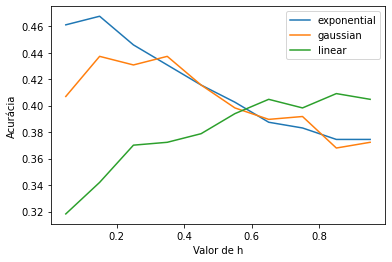

In [41]:
for kernel in kernels:
  acc = []
  print("kernel: ", kernel)
  for h in hs:
    jp = BayesianParzenWindowClassifier()
    jp.fit(X1_train, Y1_train, h, kernel)

    Y_pred, dict_predicoes = realizar_predicoes(jp, X1_test, Y1_test)

    accuracy = accuracy_score(Y1_test, Y_pred)
    acc.append(accuracy)
  
  melhor_h = hs[acc.index(max(acc))]
  print("Melhor valor de h: ", melhor_h)
  print("Acurácia com melhor h: ", max(acc), "\n")

  plt.plot(hs, acc, label=kernel)
  plt.xlabel('Valor de h')
  plt.ylabel('Acurácia')
plt.legend()
plt.show()

kernel:  exponential
Melhor valor de h:  0.35
Acurácia com melhor h:  0.9199134199134199 

kernel:  gaussian
Melhor valor de h:  0.75
Acurácia com melhor h:  0.9177489177489178 

kernel:  linear
Melhor valor de h:  0.95
Acurácia com melhor h:  0.525974025974026 



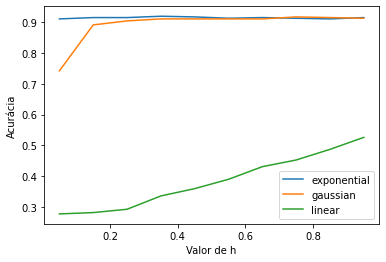

In [42]:
for kernel in kernels:
  acc = []
  print("kernel: ", kernel)
  for h in hs:
    jp = BayesianParzenWindowClassifier()
    jp.fit(X2_train, Y2_train, h, kernel)

    Y_pred, dict_predicoes = realizar_predicoes(jp, X2_test, Y2_test)

    accuracy = accuracy_score(Y2_test, Y_pred)
    acc.append(accuracy)
  
  melhor_h = hs[acc.index(max(acc))]
  print("Melhor valor de h: ", melhor_h)
  print("Acurácia com melhor h: ", max(acc), "\n")

  plt.plot(hs, acc, label=kernel)
  plt.xlabel('Valor de h')
  plt.ylabel('Acurácia')
plt.legend()
plt.show()

kernel:  exponential
Melhor valor de h:  0.25
Acurácia com melhor h:  0.922077922077922 

kernel:  gaussian
Melhor valor de h:  0.95
Acurácia com melhor h:  0.9134199134199135 

kernel:  linear
Melhor valor de h:  0.95
Acurácia com melhor h:  0.461038961038961 



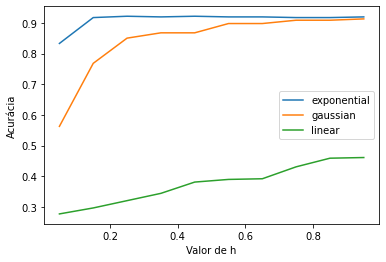

In [43]:
for kernel in kernels:
  acc = []
  print("kernel: ", kernel)
  for h in hs:
    jp = BayesianParzenWindowClassifier()
    jp.fit(X3_train, Y3_train, h, kernel)

    Y_pred, dict_predicoes = realizar_predicoes(jp, X3_test, Y3_test)

    accuracy = accuracy_score(Y3_test, Y_pred)
    acc.append(accuracy)
  
  melhor_h = hs[acc.index(max(acc))]
  print("Melhor valor de h: ", melhor_h)
  print("Acurácia com melhor h: ", max(acc), "\n")

  plt.plot(hs, acc, label=kernel)
  plt.xlabel('Valor de h')
  plt.ylabel('Acurácia')
plt.legend()
plt.show()

## k-fold

In [44]:
# https://stackoverflow.com/questions/71181291/differences-between-repeatedstratifiedkfold-and-stratifiedkfold-in-sklearn
kf1 = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=999)
kf2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=999)
kf3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=999)
kf1.get_n_splits(X1, Y)
kf2.get_n_splits(X2, Y)
kf3.get_n_splits(X3, Y)

300

## Bayesiano Gaussiano

In [45]:
nb_accuracy = [[] for i in range(3)]
nb_precision = [[] for i in range(3)]
nb_f1 = [[] for i in range(3)]
nb_recall = [[] for i in range(3)]

In [46]:
for train_id, test_id in kf1.split(X1, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  Y1_train, Y1_test = Y.iloc[train_id], Y.iloc[test_id]

  nb1 = GaussianNB()
  nb1.fit(X1_train, Y1_train)
  Y1_pred = nb1.predict(X1_test)

  nb_accuracy[0].append(accuracy_score(Y1_test, Y1_pred))
  nb_f1[0].append(f1_score(Y1_test, Y1_pred, average = "macro"))
  nb_precision[0].append(precision_score(Y1_test, Y1_pred, average = "macro"))
  nb_recall[0].append(recall_score(Y1_test, Y1_pred, average = "macro"))

grau_de_liberdade = len(nb_accuracy[0]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(nb_accuracy[0])
media_acuracias = np.mean(nb_accuracy[0])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(nb_f1[0])
media_f1s = np.mean(nb_f1[0])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(nb_precision[0])
media_precisao = np.mean(nb_precision[0])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(nb_recall[0])
media_recall = np.mean(nb_recall[0])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(nb_accuracy[0]), np.std(nb_accuracy[0])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(nb_f1[0]), np.std(nb_f1[0])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(nb_precision[0]), np.std(nb_precision[0])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(nb_recall[0]), np.std(nb_recall[0])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Bayesiano Gaussiano']:
  rankings1['Bayesiano Gaussiano'].iloc[ind] = nb_accuracy[0][ind]
  ind = ind + 1

Accuracy: 0.2933 (0.0228)
Intervalo de confiança:  (0.2907522414078811, 0.29594328528764563) 

F1-score: 0.2493 (0.0271)
Intervalo de confiança:  (0.24621036140305597, 0.2523839697151345) 

Precision: 0.3489 (0.0528)
Intervalo de confiança:  (0.34285026239644906, 0.3548673805846381) 

Recall: 0.2933 (0.0228)
Intervalo de confiança:  (0.2907522414078811, 0.29594328528764563)


In [47]:
for train_id, test_id in kf2.split(X2, Y):
    X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
    Y2_train, Y2_test = Y.iloc[train_id], Y.iloc[test_id]

    nb2 = GaussianNB()
    nb2.fit(X2_train, Y2_train)
    Y2_pred = nb2.predict(X2_test)

    nb_accuracy[1].append(accuracy_score(Y2_test, Y2_pred))
    nb_precision[1].append(precision_score(Y2_test, Y2_pred, average = "macro"))
    nb_f1[1].append(f1_score(Y2_test, Y2_pred, average = "macro"))
    nb_recall[1].append(recall_score(Y2_test, Y2_pred, average = "macro"))

grau_de_liberdade = len(nb_accuracy[1]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(nb_accuracy[1])
media_acuracias = np.mean(nb_accuracy[1])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(nb_f1[1])
media_f1s = np.mean(nb_f1[1])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(nb_precision[1])
media_precisao = np.mean(nb_precision[1])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(nb_recall[1])
media_recall = np.mean(nb_recall[1])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(nb_accuracy[1]), np.std(nb_accuracy[1])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(nb_f1[1]), np.std(nb_f1[1])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(nb_precision[1]), np.std(nb_precision[1])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(nb_recall[1]), np.std(nb_recall[1])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings2['Bayesiano Gaussiano']:
  rankings2['Bayesiano Gaussiano'].iloc[ind] = nb_accuracy[1][ind]
  ind = ind + 1

Accuracy: 0.7980 (0.0209)
Intervalo de confiança:  (0.7955971120807473, 0.8003624838788485) 

F1-score: 0.7950 (0.0211)
Intervalo de confiança:  (0.7925495136876131, 0.7973572973790113) 

Precision: 0.8022 (0.0214)
Intervalo de confiança:  (0.7997917924232415, 0.8046722310515481) 

Recall: 0.7980 (0.0209)
Intervalo de confiança:  (0.7955971120807475, 0.8003624838788486)


In [48]:
for train_id, test_id in kf3.split(X3, Y):
    X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
    Y3_train, Y3_test = Y.iloc[train_id], Y.iloc[test_id]

    nb3 = GaussianNB()
    nb3.fit(X3_train, Y3_train)
    Y3_pred = nb3.predict(X3_test)

    nb_accuracy[2].append(accuracy_score(Y3_test, Y3_pred))
    nb_precision[2].append(precision_score(Y3_test, Y3_pred, average = "macro"))
    nb_f1[2].append(f1_score(Y3_test, Y3_pred, average = "macro"))
    nb_recall[2].append(recall_score(Y3_test, Y3_pred, average = "macro"))

grau_de_liberdade = len(nb_accuracy[2]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(nb_accuracy[2])
media_acuracias = np.mean(nb_accuracy[2])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(nb_f1[2])
media_f1s = np.mean(nb_f1[2])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(nb_precision[2])
media_precisao = np.mean(nb_precision[2])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(nb_recall[2])
media_recall = np.mean(nb_recall[2])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(nb_accuracy[2]), np.std(nb_accuracy[2])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(nb_f1[2]), np.std(nb_f1[2])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(nb_precision[2]), np.std(nb_precision[2])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(nb_recall[2]), np.std(nb_recall[2])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings3['Bayesiano Gaussiano']:
  rankings3['Bayesiano Gaussiano'].iloc[ind] = nb_accuracy[2][ind]
  ind = ind + 1

Accuracy: 0.7133 (0.0223)
Intervalo de confiança:  (0.7107530167380973, 0.7158270698419891) 

F1-score: 0.6859 (0.0257)
Intervalo de confiança:  (0.6830113653840327, 0.688849798296478) 

Precision: 0.7238 (0.0328)
Intervalo de confiança:  (0.720034918051486, 0.7274958233318665) 

Recall: 0.7133 (0.0223)
Intervalo de confiança:  (0.7107530167380974, 0.7158270698419892)


## k-NN

In [49]:
knn_accuracy = [[] for i in range(3)]
knn_precision = [[] for i in range(3)]
knn_f1 = [[] for i in range(3)]
knn_recall = [[] for i in range(3)]

In [50]:
for train_id, test_id in kf1.split(X1, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  Y1_train, Y1_test = Y.iloc[train_id], Y.iloc[test_id]

  knn1 = KNeighborsClassifier(n_neighbors=16)
  knn1.fit(X1_train, Y1_train)
  Y1_pred = knn1.predict(X1_test)

  knn_accuracy[0].append(accuracy_score(Y1_test, Y1_pred))
  knn_precision[0].append(precision_score(Y1_test, Y1_pred, average = "macro"))
  knn_f1[0].append(f1_score(Y1_test, Y1_pred, average = "macro"))
  knn_recall[0].append(recall_score(Y1_test, Y1_pred, average = "macro"))

grau_de_liberdade = len(knn_accuracy[0]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(knn_accuracy[0])
media_acuracias = np.mean(knn_accuracy[0])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(knn_f1[0])
media_f1s = np.mean(knn_f1[0])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(knn_precision[0])
media_precisao = np.mean(knn_precision[0])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(knn_recall[0])
media_recall = np.mean(knn_recall[0])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(knn_accuracy[0]), np.std(knn_accuracy[0])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(knn_f1[0]), np.std(knn_f1[0])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(knn_precision[0]), np.std(knn_precision[0])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(knn_recall[0]), np.std(knn_recall[0])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Bayesiano Gaussiano']:
  rankings1['k-NN'].iloc[ind] = knn_accuracy[0][ind]
  ind = ind + 1

Accuracy: 0.4398 (0.0296)
Intervalo de confiança:  (0.4364604962972166, 0.44319318335646307) 

F1-score: 0.4300 (0.0302)
Intervalo de confiança:  (0.4265180010724509, 0.43339593470233223) 

Precision: 0.4528 (0.0331)
Intervalo de confiança:  (0.44903944949750296, 0.45658049483836016) 

Recall: 0.4398 (0.0296)
Intervalo de confiança:  (0.4364604962972166, 0.44319318335646307)


In [51]:
for train_id, test_id in kf2.split(X2, Y):
    X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
    Y2_train, Y2_test = Y.iloc[train_id], Y.iloc[test_id]

    knn2 = KNeighborsClassifier(n_neighbors=1)
    knn2.fit(X2_train, Y2_train)
    Y2_pred = knn2.predict(X2_test)

    knn_accuracy[1].append(accuracy_score(Y2_test, Y2_pred))
    knn_precision[1].append(precision_score(Y2_test, Y2_pred, average = "macro"))
    knn_f1[1].append(f1_score(Y2_test, Y2_pred, average = "macro"))
    knn_recall[1].append(recall_score(Y2_test, Y2_pred, average = "macro"))

grau_de_liberdade = len(knn_accuracy[1]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(knn_accuracy[1])
media_acuracias = np.mean(knn_accuracy[1])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(knn_f1[1])
media_f1s = np.mean(knn_f1[1])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(knn_precision[1])
media_precisao = np.mean(knn_precision[1])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(knn_recall[1])
media_recall = np.mean(knn_recall[1])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(knn_accuracy[1]), np.std(knn_accuracy[1])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(knn_f1[1]), np.std(knn_f1[1])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(knn_precision[1]), np.std(knn_precision[1])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(knn_recall[1]), np.std(knn_recall[1])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings2['k-NN']:
  rankings2['k-NN'].iloc[ind] = knn_accuracy[1][ind]
  ind = ind + 1

Accuracy: 0.9139 (0.0169)
Intervalo de confiança:  (0.9119729034155378, 0.9158193043766699) 

F1-score: 0.9138 (0.0169)
Intervalo de confiança:  (0.9118272911126616, 0.9156760482080554) 

Precision: 0.9158 (0.0166)
Intervalo de confiança:  (0.9139535298242646, 0.9177407987794021) 

Recall: 0.9139 (0.0169)
Intervalo de confiança:  (0.9119729034155378, 0.9158193043766699)


In [52]:
for train_id, test_id in kf3.split(X3, Y):
    X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
    Y3_train, Y3_test = Y.iloc[train_id], Y.iloc[test_id]

    knn3 = KNeighborsClassifier(n_neighbors=1)
    knn3.fit(X3_train, Y3_train)
    Y3_pred = knn3.predict(X3_test)

    knn_accuracy[2].append(accuracy_score(Y3_test, Y3_pred))
    knn_precision[2].append(precision_score(Y3_test, Y3_pred, average = "macro"))
    knn_f1[2].append(f1_score(Y3_test, Y3_pred, average = "macro"))
    knn_recall[2].append(recall_score(Y3_test, Y3_pred, average = "macro"))

grau_de_liberdade = len(knn_accuracy[2]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(knn_accuracy[2])
media_acuracias = np.mean(knn_accuracy[2])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(knn_f1[2])
media_f1s = np.mean(knn_f1[2])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(knn_precision[2])
media_precisao = np.mean(knn_precision[2])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(knn_recall[2])
media_recall = np.mean(knn_recall[2])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(knn_accuracy[2]), np.std(knn_accuracy[2])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(knn_f1[2]), np.std(knn_f1[2])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(knn_precision[2]), np.std(knn_precision[2])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(knn_recall[2]), np.std(knn_recall[2])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings3['k-NN']:
  rankings3['k-NN'].iloc[ind] = knn_accuracy[2][ind]
  ind = ind + 1

Accuracy: 0.9309 (0.0154)
Intervalo de confiança:  (0.9291002796991733, 0.9326024620035681) 

F1-score: 0.9304 (0.0155)
Intervalo de confiança:  (0.9286528328944063, 0.9321910680883144) 

Precision: 0.9327 (0.0151)
Intervalo de confiança:  (0.9310009693981236, 0.9344455211074767) 

Recall: 0.9309 (0.0154)
Intervalo de confiança:  (0.9291002796991733, 0.9326024620035681)


## Bayesiano com Janela de Parzen

In [53]:
jp_accuracy = [[] for i in range(3)]
jp_precision = [[] for i in range(3)]
jp_f1 = [[] for i in range(3)]
jp_recall = [[] for i in range(3)]

In [55]:
for train_id, test_id in kf1.split(X1, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  Y1_train, Y1_test = Y.iloc[train_id], Y.iloc[test_id]

  jp1 = BayesianParzenWindowClassifier()
  jp1.fit(X1_train, Y1_train, 0.15, 'exponential')

  Y_pred, dict_predicoes = realizar_predicoes(jp1, X1_test, Y1_test)

  jp_accuracy[0].append(accuracy_score(Y1_test, Y1_pred))
  jp_f1[0].append(f1_score(Y1_test, Y1_pred, average = "macro"))
  jp_precision[0].append(precision_score(Y1_test, Y1_pred, average = "macro"))
  jp_recall[0].append(recall_score(Y1_test, Y1_pred, average = "macro"))

grau_de_liberdade = len(jp_accuracy[0]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(jp_accuracy[0])
media_acuracias = np.mean(jp_accuracy[0])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(jp_f1[0])
media_f1s = np.mean(jp_f1[0])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(jp_precision[0])
media_precisao = np.mean(jp_precision[0])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(jp_recall[0])
media_recall = np.mean(jp_recall[0])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(jp_accuracy[0]), np.std(jp_accuracy[0])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(jp_f1[0]), np.std(jp_f1[0])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(jp_precision[0]), np.std(jp_precision[0])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(jp_recall[0]), np.std(jp_recall[0])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Janela de Parzen']:
  rankings1['Janela de Parzen'].iloc[ind] = jp_accuracy[0][ind]
  ind = ind + 1

Accuracy: 0.2416 (0.0375)
Intervalo de confiança:  (0.23852203297735894, 0.24477205175299152) 

F1-score: 0.2345 (0.0378)
Intervalo de confiança:  (0.2313380856194716, 0.23763017249175167) 

Precision: 0.2420 (0.0414)
Intervalo de confiança:  (0.23851426531967387, 0.24540940119283947) 

Recall: 0.2416 (0.0375)
Intervalo de confiança:  (0.23852203297735894, 0.24477205175299152)


In [56]:
for train_id, test_id in kf2.split(X2, Y):
  X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
  Y2_train, Y2_test = Y.iloc[train_id], Y.iloc[test_id]

  jp2 = BayesianParzenWindowClassifier()
  jp2.fit(X2_train, Y2_train, 0.35, 'exponential')

  Y_pred, dict_predicoes = realizar_predicoes(jp2, X2_test, Y2_test)

  jp_accuracy[1].append(accuracy_score(Y2_test, Y2_pred))
  jp_f1[1].append(f1_score(Y2_test, Y2_pred, average = "macro"))
  jp_precision[1].append(precision_score(Y2_test, Y2_pred, average = "macro"))
  jp_recall[1].append(recall_score(Y2_test, Y2_pred, average = "macro"))

grau_de_liberdade = len(jp_accuracy[1]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(jp_accuracy[1])
media_acuracias = np.mean(jp_accuracy[1])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(jp_f1[1])
media_f1s = np.mean(jp_f1[1])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(jp_precision[1])
media_precisao = np.mean(jp_precision[1])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(jp_recall[1])
media_recall = np.mean(jp_recall[1])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(jp_accuracy[1]), np.std(jp_accuracy[1])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(jp_f1[1]), np.std(jp_f1[1])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(jp_precision[1]), np.std(jp_precision[1])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(jp_recall[1]), np.std(jp_recall[1])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings2['Janela de Parzen']:
  rankings2['Janela de Parzen'].iloc[ind] = jp_accuracy[1][ind]
  ind = ind + 1

Accuracy: 0.3665 (0.1028)
Intervalo de confiança:  (0.35479594287615424, 0.37819107011085884) 

F1-score: 0.3662 (0.1026)
Intervalo de confiança:  (0.35457265560552587, 0.37792272983773045) 

Precision: 0.3662 (0.1025)
Intervalo de confiança:  (0.3545854137355459, 0.3779085979942683) 

Recall: 0.3665 (0.1028)
Intervalo de confiança:  (0.35479594287615424, 0.37819107011085884)


In [59]:
for train_id, test_id in kf3.split(X3, Y):
  X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
  Y3_train, Y3_test = Y.iloc[train_id], Y.iloc[test_id]

  jp3 = BayesianParzenWindowClassifier()
  jp3.fit(X3_train, Y3_train, 0.95, 'exponential')

  Y_pred, dict_predicoes = realizar_predicoes(jp3, X3_test, Y3_test)

  jp_accuracy[2].append(accuracy_score(Y3_test, Y3_pred))
  jp_f1[2].append(f1_score(Y3_test, Y3_pred, average = "macro"))
  jp_precision[2].append(precision_score(Y3_test, Y3_pred, average = "macro"))
  jp_recall[2].append(recall_score(Y3_test, Y3_pred, average = "macro"))

grau_de_liberdade = len(jp_accuracy[2]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(jp_accuracy[2])
media_acuracias = np.mean(jp_accuracy[2])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(jp_f1[2])
media_f1s = np.mean(jp_f1[2])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(jp_precision[2])
media_precisao = np.mean(jp_precision[2])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(jp_recall[2])
media_recall = np.mean(jp_recall[2])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(jp_accuracy[2]), np.std(jp_accuracy[2])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(jp_f1[2]), np.std(jp_f1[2])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(jp_precision[2]), np.std(jp_precision[2])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(jp_recall[2]), np.std(jp_recall[2])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings3['Janela de Parzen']:
  rankings3['Janela de Parzen'].iloc[ind] = jp_accuracy[2][ind]
  ind = ind + 1

Accuracy: 0.3664 (0.1028)
Intervalo de confiança:  (0.35472602311905954, 0.3781166897236533) 

F1-score: 0.3662 (0.1029)
Intervalo de confiança:  (0.3544884584926761, 0.37790913147954075) 

Precision: 0.3664 (0.1032)
Intervalo de confiança:  (0.35464391112449994, 0.37812796139120547) 

Recall: 0.3664 (0.1028)
Intervalo de confiança:  (0.3547260231190595, 0.37811668972365325)


## Regressão Logística

In [152]:
rl_accuracy = [[] for i in range(3)]
rl_precision = [[] for i in range(3)]
rl_f1 = [[] for i in range(3)]
rl_recall = [[] for i in range(3)]

## https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter

In [153]:
for train_id, test_id in kf1.split(X1, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  Y1_train, Y1_test = Y.iloc[train_id], Y.iloc[test_id]

  rl1 = LogisticRegression(solver='lbfgs', max_iter=1000)
  rl1.fit(X1_train, Y1_train)
  Y1_pred = rl1.predict(X1_test)

  rl_accuracy[0].append(accuracy_score(Y1_test, Y1_pred))
  rl_precision[0].append(precision_score(Y1_test, Y1_pred, average = "macro"))
  rl_f1[0].append(f1_score(Y1_test, Y1_pred, average = "macro"))
  rl_recall[0].append(recall_score(Y1_test, Y1_pred, average = "macro"))

grau_de_liberdade = len(rl_accuracy[0]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(rl_accuracy[0])
media_acuracias = np.mean(rl_accuracy[0])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(rl_f1[0])
media_f1s = np.mean(rl_f1[0])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(rl_precision[0])
media_precisao = np.mean(rl_precision[0])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(rl_recall[0])
media_recall = np.mean(rl_recall[0])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(rl_accuracy[0]), np.std(rl_accuracy[0])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(rl_f1[0]), np.std(rl_f1[0])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(rl_precision[0]), np.std(rl_precision[0])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(rl_recall[0]), np.std(rl_recall[0])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Regressão Logística']:
  rankings1['Regressão Logística'].iloc[ind] = rl_accuracy[0][ind]
  ind = ind + 1

Accuracy: 0.3194 (0.0285)
Intervalo de confiança:  (0.31618455459105377, 0.3226610442545451) 

F1-score: 0.2987 (0.0281)
Intervalo de confiança:  (0.29548611375429445, 0.3018785417154919) 

Precision: 0.3232 (0.0342)
Intervalo de confiança:  (0.31929878653252997, 0.32709141304091116) 

Recall: 0.3194 (0.0285)
Intervalo de confiança:  (0.31618455459105377, 0.3226610442545451)


In [62]:
for train_id, test_id in kf2.split(X2, Y):
    X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
    Y2_train, Y2_test = Y.iloc[train_id], Y.iloc[test_id]

    rl2 = LogisticRegression(solver='lbfgs', max_iter=1000)
    rl2.fit(X2_train, Y2_train)
    Y2_pred = rl2.predict(X2_test)

    rl_accuracy[1].append(accuracy_score(Y2_test, Y2_pred))
    rl_precision[1].append(precision_score(Y2_test, Y2_pred, average = "macro"))
    rl_f1[1].append(f1_score(Y2_test, Y2_pred, average = "macro"))
    rl_recall[1].append(recall_score(Y2_test, Y2_pred, average = "macro"))

grau_de_liberdade = len(rl_accuracy[1]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(rl_accuracy[1])
media_acuracias = np.mean(rl_accuracy[1])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(rl_f1[1])
media_f1s = np.mean(rl_f1[1])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(rl_precision[1])
media_precisao = np.mean(rl_precision[1])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(rl_recall[1])
media_recall = np.mean(rl_recall[1])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(rl_accuracy[1]), np.std(rl_accuracy[1])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(rl_f1[1]), np.std(rl_f1[1])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(rl_precision[1]), np.std(rl_precision[1])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(rl_recall[1]), np.std(rl_recall[1])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Regressão Logística']:
  rankings1['Regressão Logística'].iloc[ind] = rl_accuracy[1][ind]
  ind = ind + 1

Accuracy: 0.8469 (0.0205)
Intervalo de confiança:  (0.8445637520682158, 0.8492313417268779) 

F1-score: 0.8431 (0.0211)
Intervalo de confiança:  (0.8407029543208249, 0.8455050819814904) 

Precision: 0.8446 (0.0216)
Intervalo de confiança:  (0.8421361801023961, 0.8470592638650789) 

Recall: 0.8469 (0.0205)
Intervalo de confiança:  (0.8445637520682159, 0.849231341726878)


In [63]:
for train_id, test_id in kf3.split(X3, Y):
    X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
    Y3_train, Y3_test = Y.iloc[train_id], Y.iloc[test_id]

    rl3 = LogisticRegression(solver='lbfgs', max_iter=1000)
    rl3.fit(X3_train, Y3_train)
    Y3_pred = rl3.predict(X3_test)

    rl_accuracy[2].append(accuracy_score(Y3_test, Y3_pred))
    rl_precision[2].append(precision_score(Y3_test, Y3_pred, average = "macro"))
    rl_f1[2].append(f1_score(Y3_test, Y3_pred, average = "macro"))
    rl_recall[2].append(recall_score(Y3_test, Y3_pred, average = "macro"))

grau_de_liberdade = len(rl_accuracy[2]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(rl_accuracy[2])
media_acuracias = np.mean(rl_accuracy[2])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(rl_f1[2])
media_f1s = np.mean(rl_f1[2])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(rl_precision[2])
media_precisao = np.mean(rl_precision[2])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(rl_recall[2])
media_recall = np.mean(rl_recall[2])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(rl_accuracy[2]), np.std(rl_accuracy[2])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(rl_f1[2]), np.std(rl_f1[2])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(rl_precision[2]), np.std(rl_precision[2])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(rl_recall[2]), np.std(rl_recall[2])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Regressão Logística']:
  rankings1['Regressão Logística'].iloc[ind] = rl_accuracy[2][ind]
  ind = ind + 1

Accuracy: 0.8870 (0.0190)
Intervalo de confiança:  (0.8847923197267172, 0.8891182141838164) 

F1-score: 0.8860 (0.0192)
Intervalo de confiança:  (0.88379607991745, 0.8881574375898997) 

Precision: 0.8886 (0.0192)
Intervalo de confiança:  (0.8863674912970559, 0.8907381710052386) 

Recall: 0.8870 (0.0190)
Intervalo de confiança:  (0.8847923197267172, 0.8891182141838164)


## Voto Majoritário

In [148]:
class VotingClassifier:

  def realizar_predicoes(self, nb, knn, jp, rl, df_X, df_Y):

    apriori = self.calcular_probabilidade_apriori(df_X, df_Y)

    ##Preparação dos dados
    df_X = df_X.drop(["CLASSE"], axis=1)
    df_Y = data["CLASS"]

    classes = df_Y.drop_duplicates()
    predicoes_classes = {}

    array_predicoes_ensemble = []

    i = 0
    #predicoes_classes['CYT']
    for entrada in df_X.values:
      pred_nb = nb.predict(entrada.reshape(1, -1))[0]
      pred_knn = knn.predict(entrada.reshape(1, -1))[0]
      pred_jp = jp.predict(entrada)[1]
      pred_lgr = rl.predict(entrada.reshape(1, -1))[0]

      ##Preparando as estrutura para armazenar os dados
      classes = df_Y.drop_duplicates()
      predicoes_classes = {}

      for classe in classes: 
        predicoes_classes[classe] = 0

      for classe in classes:
        if (classe == pred_nb):
          predicoes_classes[classe] = predicoes_classes[classe] + 1

        if (classe == pred_knn):
          predicoes_classes[classe] = predicoes_classes[classe] + 1

        if (classe == pred_jp):
          predicoes_classes[classe] = predicoes_classes[classe] + 1

        if (classe == pred_lgr):
          predicoes_classes[classe] = predicoes_classes[classe] + 1
      
      classe_mais_votada = [k for k, v in predicoes_classes.items() if v == max(predicoes_classes.values())]
      
      if (len(classe_mais_votada) == 1):
        array_predicoes_ensemble.append(classe_mais_votada[0])
      else:
        dict_tmp = {}
        for mais_votada in classe_mais_votada:
          dict_tmp[mais_votada] = apriori[mais_votada]
          
        mais_votada = [k for k, v in dict_tmp.items() if v == max(dict_tmp.values())]
        array_predicoes_ensemble.append(mais_votada[0])


    return array_predicoes_ensemble

  #Função para calcular a probabilidade a priori a ser utilizada para desempate
  def calcular_probabilidade_apriori(self, X, Y):
    X['CLASSE'] = Y
    classes = Y.drop_duplicates()
    dict_apriori = {}

    i = 0
    for classe in classes:
      dict_apriori[classe] = len(X[X[X.columns[-1]] == classe])/len(X)
      i =  i + 1

    return dict_apriori

In [149]:
vm_accuracy = [[] for i in range(3)]
vm_f1 = [[] for i in range(3)]
vm_precision = [[] for i in range(3)]
vm_recall = [[] for i in range(3)]

In [155]:
for train_id, test_id in kf1.split(X1, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  Y1_train, Y1_test = Y.iloc[train_id], Y.iloc[test_id]
  
  vm1 = VotingClassifier()
  Y1_pred = vm1.realizar_predicoes(nb1, knn1, jp1, rl1, X1_test, Y1_test)

  vm_accuracy[0].append(accuracy_score(Y1_test, Y1_pred))
  vm_f1[0].append(f1_score(Y1_test, Y1_pred, average = "macro"))
  vm_precision[0].append(precision_score(Y1_test, Y1_pred, average = "macro"))
  vm_recall[0].append(recall_score(Y1_test, Y1_pred, average = "macro"))

grau_de_liberdade = len(vm_accuracy[0]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(vm_accuracy[0])
media_acuracias = np.mean(vm_accuracy[0])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(vm_f1[0])
media_f1s = np.mean(vm_f1[0])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(vm_precision[0])
media_precisao = np.mean(vm_precision[0])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(vm_recall[0])
media_recall = np.mean(vm_recall[0])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(vm_accuracy[0]), np.std(vm_accuracy[0])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(vm_f1[0]), np.std(vm_f1[0])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(vm_precision[0]), np.std(vm_precision[0])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(vm_recall[0]), np.std(vm_recall[0])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings1['Voto Majoritário']:
  rankings1['Voto Majoritário'].iloc[ind] = vm_accuracy[0][ind]
  ind = ind + 1

Accuracy: 0.5273 (0.0280)
Intervalo de confiança:  (0.5240810847915081, 0.5304643697539466) 

F1-score: 0.5194 (0.0308)
Intervalo de confiança:  (0.5159265690349057, 0.5229434713638803) 

Precision: 0.6178 (0.0329)
Intervalo de confiança:  (0.6140189430444104, 0.6214982049861696) 

Recall: 0.5273 (0.0280)
Intervalo de confiança:  (0.5240810847915081, 0.5304643697539466)


In [156]:
for train_id, test_id in kf2.split(X2, Y):
  X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
  Y2_train, Y2_test = Y.iloc[train_id], Y.iloc[test_id]

  vm2 = VotingClassifier()
  Y2_pred = vm2.realizar_predicoes(nb2, knn2, jp2, rl2, X2_test, Y2_test)

  vm_accuracy[1].append(accuracy_score(Y2_test, Y2_pred))
  vm_f1[1].append(f1_score(Y2_test, Y2_pred, average = "macro"))
  vm_precision[1].append(precision_score(Y2_test, Y2_pred, average = "macro"))
  vm_recall[1].append(recall_score(Y2_test, Y2_pred, average = "macro"))

grau_de_liberdade = len(vm_accuracy[1]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(vm_accuracy[1])
media_acuracias = np.mean(vm_accuracy[1])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(vm_f1[1])
media_f1s = np.mean(vm_f1[1])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(vm_precision[1])
media_precisao = np.mean(vm_precision[1])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(vm_recall[1])
media_recall = np.mean(vm_recall[1])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(vm_accuracy[1]), np.std(vm_accuracy[1])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(vm_f1[1]), np.std(vm_f1[1])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(vm_precision[1]), np.std(vm_precision[1])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(vm_recall[1]), np.std(vm_recall[1])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings2['Voto Majoritário']:
  rankings2['Voto Majoritário'].iloc[ind] = vm_accuracy[1][ind]
  ind = ind + 1

Accuracy: 0.1429 (0.0000)
Intervalo de confiança:  (0.14285714285714282, 0.14285714285714282) 

F1-score: 0.0357 (0.0000)
Intervalo de confiança:  (0.035714285714285705, 0.035714285714285705) 

Precision: 0.0204 (0.0000)
Intervalo de confiança:  (nan, nan) 

Recall: 0.1429 (0.0000)
Intervalo de confiança:  (0.14285714285714282, 0.14285714285714282)


In [157]:
for train_id, test_id in kf3.split(X3, Y):
  X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
  Y3_train, Y3_test = Y.iloc[train_id], Y.iloc[test_id]

  vm3 = VotingClassifier()
  Y3_pred = vm3.realizar_predicoes(nb3, knn3, jp3, rl3, X3_test, Y3_test)

  vm_accuracy[2].append(accuracy_score(Y3_test, Y3_pred))
  vm_f1[2].append(f1_score(Y3_test, Y3_pred, average = "macro"))
  vm_precision[2].append(precision_score(Y3_test, Y3_pred, average = "macro"))
  vm_recall[2].append(recall_score(Y3_test, Y3_pred, average = "macro"))

grau_de_liberdade = len(vm_accuracy[2]) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(vm_accuracy[2])
media_acuracias = np.mean(vm_accuracy[2])
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(vm_f1[2])
media_f1s = np.mean(vm_f1[2])
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(vm_precision[2])
media_precisao = np.mean(vm_precision[2])
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Recall
erro_padrao_recall = sem(vm_recall[2])
media_recall = np.mean(vm_recall[2])
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Accuracy: %.4f (%.4f)" % (np.mean(vm_accuracy[2]), np.std(vm_accuracy[2])))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F1-score: %.4f (%.4f)" % (np.mean(vm_f1[2]), np.std(vm_f1[2])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precision: %.4f (%.4f)" % (np.mean(vm_precision[2]), np.std(vm_precision[2])))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Recall: %.4f (%.4f)" % (np.mean(vm_recall[2]), np.std(vm_recall[2])))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings3['Voto Majoritário']:
  rankings3['Voto Majoritário'].iloc[ind] = vm_accuracy[2][ind]
  ind = ind + 1

Accuracy: 0.1429 (0.0000)
Intervalo de confiança:  (0.14285714285714282, 0.14285714285714282) 

F1-score: 0.0357 (0.0000)
Intervalo de confiança:  (0.035714285714285705, 0.035714285714285705) 

Precision: 0.0204 (0.0000)
Intervalo de confiança:  (nan, nan) 

Recall: 0.1429 (0.0000)
Intervalo de confiança:  (0.14285714285714282, 0.14285714285714282)


## Teste de Friedman

In [158]:
#Estabelecendo significância de 95%
dados = np.asarray(rankings1)

stat, p = friedmanchisquare(dados[0], dados[1], dados[2], dados[3], dados[4])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretaando o teste
alpha = 0.05
if p > alpha:
	print('Mesmas distribuições (falha em rejeitar H0)')
else:
	print('Distribuições diferentes (H0 rejeitada)')

Statistics=4.204, p=0.379
Mesmas distribuições (falha em rejeitar H0)


In [159]:
rankings1

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística,Voto Majoritário
0,0.350649,0.445887,0.203463,0.359307,0.471861
1,0.285714,0.363636,0.220779,0.303030,0.480519
2,0.277056,0.450216,0.255411,0.298701,0.523810
3,0.264069,0.445887,0.242424,0.376623,0.601732
4,0.337662,0.463203,0.242424,0.320346,0.545455


In [160]:
#Estabelecendo significância de 95%
dados = np.asarray(rankings2)

stat, p = friedmanchisquare(dados[0], dados[1], dados[2], dados[3], dados[4])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretaando o teste
alpha = 0.05
if p > alpha:
	print('Mesmas distribuições (falha em rejeitar H0)')
else:
	print('Distribuições diferentes (H0 rejeitada)')

Statistics=6.035, p=0.197
Mesmas distribuições (falha em rejeitar H0)


In [161]:
rankings2

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística,Voto Majoritário
0,0.774892,0.900433,0.298701,0.0,0.142857
1,0.796537,0.922078,0.428571,0.0,0.142857
2,0.796537,0.926407,0.463203,0.0,0.142857
3,0.818182,0.930736,0.411255,0.0,0.142857
4,0.818182,0.900433,0.264069,0.0,0.142857


In [162]:
#Estabelecendo significância de 95%
dados = np.asarray(rankings3)

stat, p = friedmanchisquare(dados[0], dados[1], dados[2], dados[3], dados[4])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretaando o teste
alpha = 0.05
if p > alpha:
	print('Mesmas distribuições (falha em rejeitar H0)')
else:
	print('Distribuições diferentes (H0 rejeitada)')

Statistics=0.483, p=0.975
Mesmas distribuições (falha em rejeitar H0)


In [163]:
rankings3

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística,Voto Majoritário
0,0.709957,0.913420,0.285714,0.0,0.142857
1,0.679654,0.956710,0.419913,0.0,0.142857
2,0.705628,0.913420,0.467532,0.0,0.142857
3,0.705628,0.952381,0.406926,0.0,0.142857
4,0.740260,0.935065,0.264069,0.0,0.142857


#### Ranqueamento dos classificadores

In [164]:
result = autorank(rankings1, alpha=0.05, verbose=False)
print(result)

RankResult(rankdf=
                     meanrank      mean       std  ci_lower  ci_upper  \
Janela de Parzen          5.0  0.232900  0.020625  0.196288  0.269512   
Bayesiano Gaussiano       3.8  0.303030  0.038599  0.266418  0.339642   
Regressão Logística       3.2  0.331602  0.034713   0.29499  0.368214   
k-NN                      2.0  0.433766  0.039841  0.397154  0.470378   
Voto Majoritário          1.0  0.524675  0.052700  0.488063  0.561287   

                    effect_size   magnitude  
Janela de Parzen            0.0  negligible  
Bayesiano Gaussiano   -2.266233       large  
Regressão Logística   -3.456927       large  
k-NN                  -6.331853       large  
Voto Majoritário      -7.291281       large  
pvalue=5.903753676167226e-09
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.012640677392482758, 0.34052860736846924, 0.2832370102405548, 0.5869212746620178, 0.6400901079177856]
homoscedastic=True
pval_homogeneity=0.5711362466375545
homogenei

In [165]:
result = autorank(rankings2, alpha=0.05, verbose=False)
print(result)

RankResult(rankdf=
                     meanrank      mean       std  ci_lower  ci_upper  \
Regressão Logística       5.0  0.000000  0.000000       0.0       0.0   
Voto Majoritário          4.0  0.142857  0.000000  0.142857  0.142857   
Janela de Parzen          3.0  0.373160  0.086710  0.194623  0.551697   
Bayesiano Gaussiano       2.0  0.800866  0.018110  0.763578  0.838154   
k-NN                      1.0  0.916017  0.014552  0.886054   0.94598   

                    effect_size magnitude  
Regressão Logística         NaN     large  
Voto Majoritário           -inf     large  
Janela de Parzen      -6.086138     large  
Bayesiano Gaussiano  -62.541415     large  
k-NN                 -89.020789     large  
pvalue=0.0004993992273873336
cd=2.7277508838690387
omnibus=friedman
posthoc=nemenyi
all_normal=True
pvals_shapiro=[1.0, 1.0, 0.3622746169567108, 0.31403911113739014, 0.12400577962398529]
homoscedastic=False
pval_homogeneity=0.0
homogeneity_test=bartlett
alpha=0.05
alpha_normali

In [166]:
result = autorank(rankings3, alpha=0.05, verbose=False)
print(result)

RankResult(rankdf=
                     meanrank      mean       std  ci_lower  ci_upper  \
Regressão Logística       5.0  0.000000  0.000000       0.0       0.0   
Voto Majoritário          4.0  0.142857  0.000000  0.142857  0.142857   
Janela de Parzen          3.0  0.368831  0.089003  0.185573  0.552089   
Bayesiano Gaussiano       2.0  0.708225  0.021558  0.663836  0.752614   
k-NN                      1.0  0.934199  0.020625  0.891731  0.976667   

                    effect_size magnitude  
Regressão Logística         NaN     large  
Voto Majoritário           -inf     large  
Janela de Parzen      -5.860551     large  
Bayesiano Gaussiano  -46.459278     large  
k-NN                  -64.05507     large  
pvalue=0.0004993992273873336
cd=2.7277508838690387
omnibus=friedman
posthoc=nemenyi
all_normal=True
pvals_shapiro=[1.0, 1.0, 0.3408450186252594, 0.5213919281959534, 0.2158804088830948]
homoscedastic=False
pval_homogeneity=0.0
homogeneity_test=bartlett
alpha=0.05
alpha_normality

## Teste de Nemenyi

In [167]:
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

In [168]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, dados, rankings1.columns)
nemenyi_scores

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística,Voto Majoritário
Bayesiano Gaussiano,1.000000,0.837822,0.837822,0.022661,0.265918
k-NN,0.837822,1.000000,0.265918,0.001000,0.022661
Janela de Parzen,0.837822,0.265918,1.000000,0.265918,0.837822
Regressão Logística,0.022661,0.001000,0.265918,1.000000,0.837822
Voto Majoritário,0.265918,0.022661,0.837822,0.837822,1.000000


In [169]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, dados, rankings2.columns)
nemenyi_scores

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística,Voto Majoritário
Bayesiano Gaussiano,1.000000,0.837822,0.837822,0.022661,0.265918
k-NN,0.837822,1.000000,0.265918,0.001000,0.022661
Janela de Parzen,0.837822,0.265918,1.000000,0.265918,0.837822
Regressão Logística,0.022661,0.001000,0.265918,1.000000,0.837822
Voto Majoritário,0.265918,0.022661,0.837822,0.837822,1.000000


In [170]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, dados, rankings3.columns)
nemenyi_scores

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística,Voto Majoritário
Bayesiano Gaussiano,1.000000,0.837822,0.837822,0.022661,0.265918
k-NN,0.837822,1.000000,0.265918,0.001000,0.022661
Janela de Parzen,0.837822,0.265918,1.000000,0.265918,0.837822
Regressão Logística,0.022661,0.001000,0.265918,1.000000,0.837822
Voto Majoritário,0.265918,0.022661,0.837822,0.837822,1.000000
